### Experiment 1 - Checking how a GAN performs when discriminator is converted to fully convolutional

This is to check how the vanilla GAN framework performs in a 'DC-GAN' setting after the discriminator is changed from fully convolutional layers are changed to densely connected layers. First we will train a standard DCGAN. In the second experiment, we will change the discriminator tp be fully convolutional to look at the effect.

In [3]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

Load a standard dataset for experiments. MNIST and SVHN 

In [2]:
classes = [i for i in range(10)]
instances = [7000 for i in range(10)]
batchSize = 256

mnist_dataset = loadDataset('MNIST', classes, instances, 'train')
mnist_dataloader = torch.utils.data.DataLoader(mnist_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

svhn_dataset = loadDataset('SVHN', classes, instances, 'train')
svhn_dataloader = torch.utils.data.DataLoader(svhn_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

Let's set the parameters for training

In [4]:
numInputChannels = 100
numGenFilter = 64
numDiscFilter = 64
numOutputChannels = 1


learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

In [5]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    


    plt.show()

### Sub-Experiment 1

First, train a fully convolutional generator and fully convolutional discriminator.

<img src="./images/DCGAN.png">

Generator :(100) $\rightarrow$ (512,4,4) $\rightarrow$ (256,8,8) $\rightarrow$ (128,16,16) $\rightarrow$ (1,32,32)

Discriminator :(1,32,32) $\rightarrow$ (128,16,16) $\rightarrow$ (256,8,8) $\rightarrow$ (512,4,4) $\rightarrow$ 1 

In [24]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels, numDiscFilter)
    
    #initialize the weights here
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numInputChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    

    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts   
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            #print discRealInput.shape
            discRealOutput = D(discRealInputV)
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutput.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

#### Result for MNIST

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/30] time: 50.92, loss_d: 0.374, loss_g: 4.057
Epoch : [2/30] time: 50.48, loss_d: 0.454, loss_g: 2.973
Epoch : [3/30] time: 50.47, loss_d: 0.596, loss_g: 2.395
Epoch : [4/30] time: 50.46, loss_d: 0.614, loss_g: 2.088
Epoch : [5/30] time: 50.46, loss_d: 0.782, loss_g: 1.844
Epoch : [6/30] time: 50.41, loss_d: 0.716, loss_g: 1.920
Epoch : [7/30] time: 50.43, loss_d: 0.631, loss_g: 2.197
Epoch : [8/30] time: 50.43, loss_d: 0.585, loss_g: 2.279
Epoch : [9/30] time: 50.38, loss_d: 0.466, loss_g: 2.644
Epoch : [10/30] time: 50.37, loss_d: 0.450, loss_g: 2.847
Epoch : [11/30] time: 50.40, loss_d: 0.528, loss_g: 2.806
Epoch : [12/30] time: 50.39, loss_d: 0.361, loss_g: 3.043
Epoch : [13/30] time: 50.43, loss_d: 0.446, loss_g: 3.150
Epoch : [14/30] time: 50.41, loss_d: 0.178, loss_g: 3.653
Epoch : [15/30] time: 50.42, loss_d: 0.673, loss_g: 2.391
Epoch : [16/30] time: 50.41, loss_d: 0.335, loss_g: 3.593
Epoch : [17/30] time: 50.40, loss_d: 0.249, loss_g: 3.602
Epoch : [18/30] time: 5

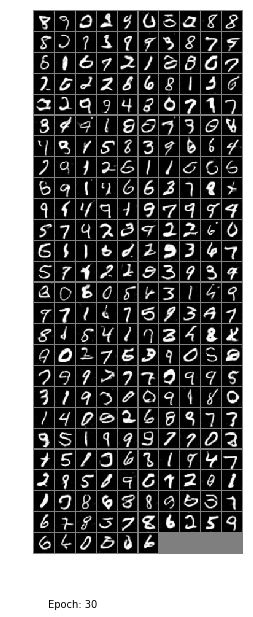

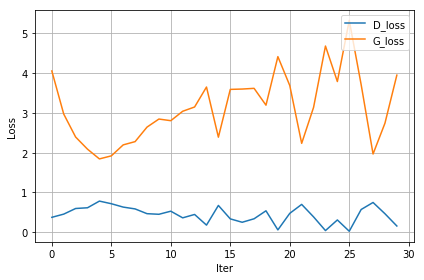

In [8]:
from model import Generator, Discriminator

train(mnist_dataloader, epochs=30)

#### Result for SVHN

Epoch : [1/30] time: 48.36, loss_d: 0.292, loss_g: 5.773
Epoch : [2/30] time: 51.68, loss_d: 0.488, loss_g: 4.189
Epoch : [3/30] time: 51.64, loss_d: 0.779, loss_g: 2.776
Epoch : [4/30] time: 51.68, loss_d: 0.880, loss_g: 2.260
Epoch : [5/30] time: 51.64, loss_d: 0.890, loss_g: 2.056
Epoch : [6/30] time: 51.64, loss_d: 0.799, loss_g: 2.067
Epoch : [7/30] time: 51.67, loss_d: 0.763, loss_g: 2.015
Epoch : [8/30] time: 51.62, loss_d: 0.693, loss_g: 2.097
Epoch : [9/30] time: 51.67, loss_d: 0.752, loss_g: 2.039
Epoch : [10/30] time: 51.60, loss_d: 0.796, loss_g: 2.002
Epoch : [11/30] time: 51.62, loss_d: 0.749, loss_g: 1.838
Epoch : [12/30] time: 51.60, loss_d: 0.834, loss_g: 1.854
Epoch : [13/30] time: 51.60, loss_d: 0.883, loss_g: 1.805
Epoch : [14/30] time: 51.63, loss_d: 0.804, loss_g: 1.743
Epoch : [15/30] time: 51.66, loss_d: 0.788, loss_g: 1.791
Epoch : [16/30] time: 51.73, loss_d: 0.837, loss_g: 1.803
Epoch : [17/30] time: 51.60, loss_d: 0.828, loss_g: 1.790
Epoch : [18/30] time: 5

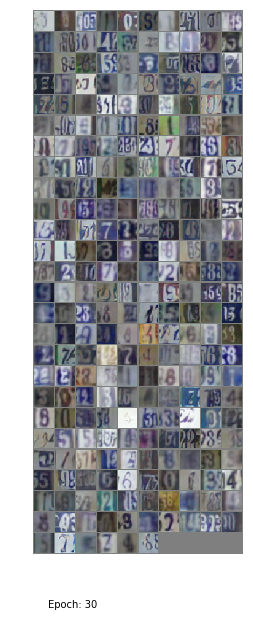

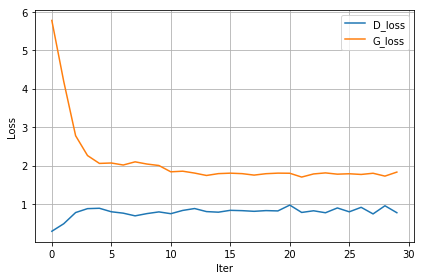

In [25]:
from model import Generator, Discriminator
numOutputChannels =3


train(svhn_dataloader, epochs=30)

### Sub-Experiment 2

Now, train a fully convolutional generator and densley connected discriminator.

<img src="./images/DCGAN_disc.png"  >

Generator : (100) $\rightarrow$ (512,4,4) $\rightarrow$ (256,8,8) $\rightarrow$ (128,16,16) $\rightarrow$ (1,32,32)

Discriminator :1024 $\rightarrow$ 1024 $\rightarrow$ 512 $\rightarrow$ 256  $\rightarrow$ 128  $\rightarrow$ 1

In [6]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels)
    
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numInputChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    
    
    
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts    
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            discRealOutput = D(discRealInputV.view(batchSize,-1))
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            genFakeOutput = genFakeOutput.view(batchSize,-1)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutput.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/30] time: 20.84, loss_d: 1.127, loss_g: 0.846
Epoch : [2/30] time: 15.11, loss_d: 0.644, loss_g: 1.312
Epoch : [3/30] time: 16.60, loss_d: 0.359, loss_g: 1.907
Epoch : [4/30] time: 16.86, loss_d: 0.224, loss_g: 2.383
Epoch : [5/30] time: 16.89, loss_d: 0.173, loss_g: 2.697
Epoch : [6/30] time: 16.92, loss_d: 0.119, loss_g: 3.082
Epoch : [7/30] time: 16.96, loss_d: 0.124, loss_g: 3.049
Epoch : [8/30] time: 16.90, loss_d: 0.085, loss_g: 3.383
Epoch : [9/30] time: 16.89, loss_d: 0.059, loss_g: 3.745
Epoch : [10/30] time: 16.90, loss_d: 0.043, loss_g: 4.100
Epoch : [11/30] time: 16.95, loss_d: 0.035, loss_g: 4.282
Epoch : [12/30] time: 16.88, loss_d: 0.047, loss_g: 4.145
Epoch : [13/30] time: 16.88, loss_d: 0.034, loss_g: 4.348
Epoch : [14/30] time: 16.86, loss_d: 0.037, loss_g: 4.358
Epoch : [15/30] time: 16.92, loss_d: 0.025, loss_g: 4.667
Epoch : [16/30] time: 16.89, loss_d: 0.027, loss_g: 4.985
Epoch : [17/30] time: 16.90, loss_d: 0.021, loss_g: 5.108
Epoch : [18/30] time: 1

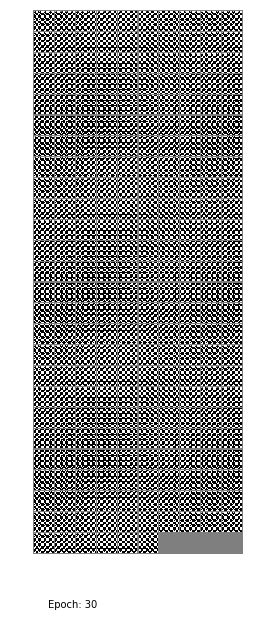

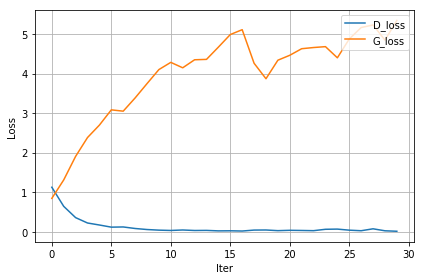

In [7]:
from model_alt import Generator, Discriminator

train(mnist_dataloader, epochs=30)

Epoch : [1/30] time: 15.85, loss_d: 1.088, loss_g: 0.884
Epoch : [2/30] time: 15.92, loss_d: 0.720, loss_g: 1.229
Epoch : [3/30] time: 18.07, loss_d: 1.169, loss_g: 1.001
Epoch : [4/30] time: 18.06, loss_d: 1.264, loss_g: 0.898
Epoch : [5/30] time: 18.08, loss_d: 1.269, loss_g: 0.896
Epoch : [6/30] time: 18.07, loss_d: 1.253, loss_g: 0.913
Epoch : [7/30] time: 18.08, loss_d: 1.284, loss_g: 0.897
Epoch : [8/30] time: 18.01, loss_d: 1.310, loss_g: 0.870
Epoch : [9/30] time: 18.02, loss_d: 1.305, loss_g: 0.880
Epoch : [10/30] time: 18.06, loss_d: 1.300, loss_g: 0.889
Epoch : [11/30] time: 18.07, loss_d: 1.305, loss_g: 0.884
Epoch : [12/30] time: 17.99, loss_d: 1.305, loss_g: 0.884
Epoch : [13/30] time: 18.04, loss_d: 1.316, loss_g: 0.875
Epoch : [14/30] time: 18.05, loss_d: 1.316, loss_g: 0.884
Epoch : [15/30] time: 18.02, loss_d: 1.309, loss_g: 0.888
Epoch : [16/30] time: 18.02, loss_d: 1.294, loss_g: 0.926
Epoch : [17/30] time: 18.03, loss_d: 1.295, loss_g: 0.919
Epoch : [18/30] time: 1

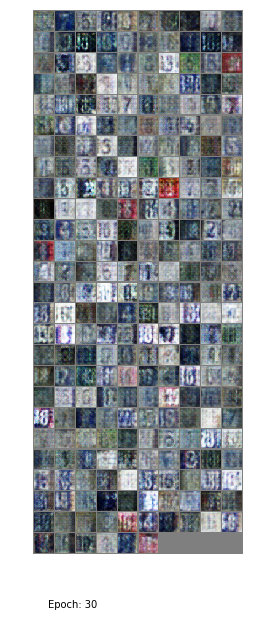

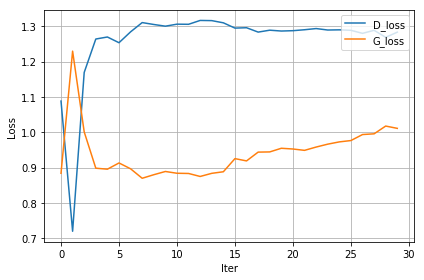

In [30]:
from model_alt import Generator, Discriminator

numOutputChannels = 3
train(svhn_dataloader, epochs=30)

### Sub-Experiment 3 

Now, train aconditional GAN with fully convolutional generator and fully convolutional discriminator.

<img src="./images/cDCGAN.png"  >

                 
Generator : (100)+(10)   $\rightarrow$ (256,4,4)+(256,4,4)  $\rightarrow$ (512,4,4) $\rightarrow$ (256,8,8) $\rightarrow$ (128,16,16) $\rightarrow$ (1,32,32) 


Discriminator : (1,32,32)+(10,32,32) $\rightarrow$ (64,16,16)+(64,16,16) $\rightarrow$ (256,8,8) $\rightarrow$ (512,4,4)  $\rightarrow$  1

In [14]:
# Additional parameters to be defined for class conditional GAN 
numClasses = 10

In [15]:
def getProbDist(primaryInstanceList):
    '''
    probability distribution over primaryInstances
    '''
    probList = []
    sumList = float(sum(primaryInstanceList))
    for i, item in enumerate(primaryInstanceList):
        probList.append(item/sumList)
    return probList

In [16]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numClasses, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels, numClasses, numDiscFilter)
    
    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                      numClasses,
                                      imageSize,
                                      imageSize)
    discFakeInputClass = torch.zeros(batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numInputChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    
    # can take the oneHot representation to feed into discriminator directly from here
    oneHotDisc = torch.zeros([numClasses, numClasses, imageSize, imageSize])
    for i in range(numClasses):
        oneHotDisc[i,i,:,:] = 1
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataClass = data
            
            # one-hot encoding for discriminator class input
            dataClass = oneHotDisc[dataClass]
            
            if cuda:
                dataInstance = dataInstance.cuda()
                dataClass = dataClass.cuda()
            
            
            #print discRealInput.shape, dataInstance.shape
            
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            discRealInputClass.copy_(dataClass)

            discRealInputV = Variable(discRealInput)
            discRealInputClassV = Variable(discRealInputClass)
            discRealLabelV = Variable(discRealLabel)
            
            discRealOutput = D(discRealInputV,
                               discRealInputClassV)
            
            
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            #  p=getProbDist(primaryInstanceList)
            dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
            discFakeInputClass = oneHotDisc[dataFakeClass]
            genFakeInputClass = oneHotGen[dataFakeClass]
            
            if cuda:
                discFakeInputClass = discFakeInputClass.cuda()
                genFakeInputClass = genFakeInputClass.cuda()

                
            discFakeInput.normal_(0,1)
            
            discFakeInputClassV= Variable(discFakeInputClass)
            genFakeInputClassV = Variable(genFakeInputClass)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            
            genFakeOutput = G(discFakeInputV,
                              genFakeInputClassV)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutput.detach(),
                               discFakeInputClassV)
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput,
                               discFakeInputClassV)
            
            genLossFake = lossFunction(discFakeOutput, 
                                       discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

Epoch : [1/30] time: 50.36, loss_d: 0.479, loss_g: 3.922
Epoch : [2/30] time: 54.17, loss_d: 0.516, loss_g: 3.129
Epoch : [3/30] time: 54.26, loss_d: 0.472, loss_g: 3.027
Epoch : [4/30] time: 54.18, loss_d: 0.575, loss_g: 2.625
Epoch : [5/30] time: 53.71, loss_d: 0.818, loss_g: 2.040
Epoch : [6/30] time: 54.12, loss_d: 1.030, loss_g: 1.559
Epoch : [7/30] time: 53.93, loss_d: 1.063, loss_g: 1.414
Epoch : [8/30] time: 53.66, loss_d: 1.036, loss_g: 1.422
Epoch : [9/30] time: 53.54, loss_d: 1.045, loss_g: 1.417
Epoch : [10/30] time: 53.91, loss_d: 1.022, loss_g: 1.468
Epoch : [11/30] time: 53.83, loss_d: 0.911, loss_g: 1.633
Epoch : [12/30] time: 53.58, loss_d: 0.888, loss_g: 1.809
Epoch : [13/30] time: 54.27, loss_d: 0.817, loss_g: 1.869
Epoch : [14/30] time: 54.15, loss_d: 0.728, loss_g: 2.133
Epoch : [15/30] time: 53.88, loss_d: 0.623, loss_g: 2.263
Epoch : [16/30] time: 54.17, loss_d: 0.583, loss_g: 2.500
Epoch : [17/30] time: 54.00, loss_d: 0.512, loss_g: 2.676
Epoch : [18/30] time: 5

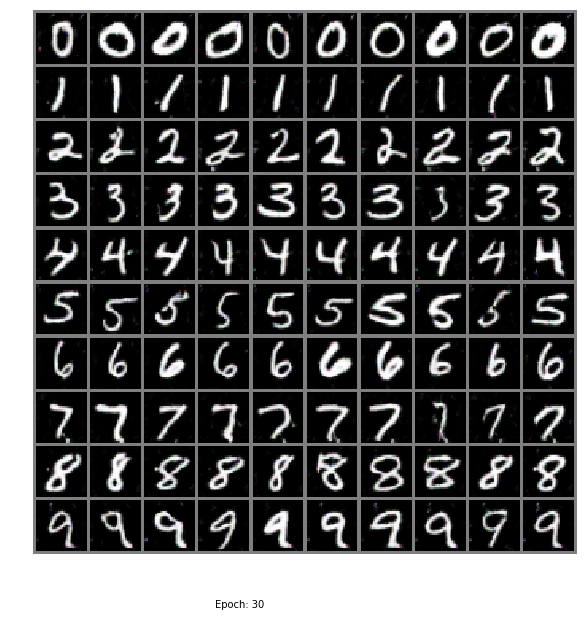

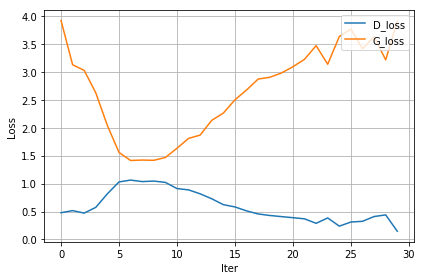

In [17]:
from model_C import Generator, Discriminator

train(mnist_dataloader, epochs=30)

Epoch : [1/60] time: 55.04, loss_d: 0.360, loss_g: 4.831
Epoch : [2/60] time: 55.03, loss_d: 0.571, loss_g: 3.224
Epoch : [3/60] time: 55.13, loss_d: 0.787, loss_g: 2.408
Epoch : [4/60] time: 54.79, loss_d: 0.742, loss_g: 2.466
Epoch : [5/60] time: 55.09, loss_d: 0.767, loss_g: 2.340
Epoch : [6/60] time: 55.18, loss_d: 0.717, loss_g: 2.407
Epoch : [7/60] time: 55.09, loss_d: 0.680, loss_g: 2.521
Epoch : [8/60] time: 55.14, loss_d: 0.623, loss_g: 2.547
Epoch : [9/60] time: 55.13, loss_d: 0.679, loss_g: 2.554
Epoch : [10/60] time: 54.58, loss_d: 0.647, loss_g: 2.569
Epoch : [11/60] time: 55.10, loss_d: 0.706, loss_g: 2.485
Epoch : [12/60] time: 55.07, loss_d: 0.674, loss_g: 2.487
Epoch : [13/60] time: 54.94, loss_d: 0.623, loss_g: 2.587
Epoch : [14/60] time: 55.19, loss_d: 0.592, loss_g: 2.826
Epoch : [15/60] time: 55.10, loss_d: 0.613, loss_g: 2.823
Epoch : [16/60] time: 54.86, loss_d: 0.606, loss_g: 2.757
Epoch : [17/60] time: 55.08, loss_d: 0.682, loss_g: 2.774
Epoch : [18/60] time: 5

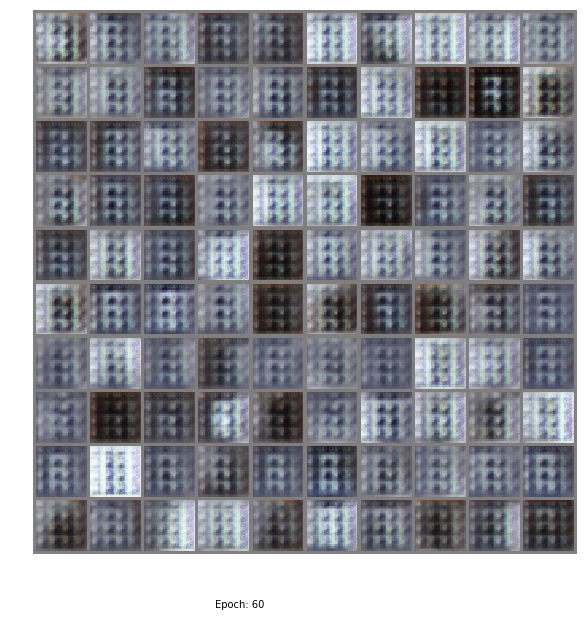

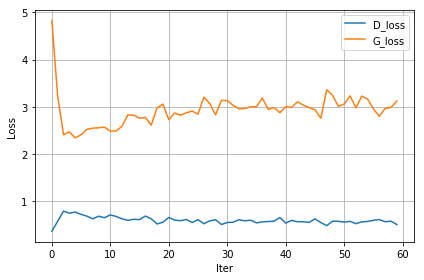

In [18]:
from model_C import Generator, Discriminator

numOutputChannels = 3
train(svhn_dataloader, epochs=60)

### Sub-Experiment 4

Now, train aconditional GAN with fully convolutional generator and densely connected discriminator.

<img src="./images/cDCGAN_disc.png"  >

Generator :(100)+(10)   $\rightarrow$ (256,4,4)+(256,4,4)  $\rightarrow$ (512,4,4) $\rightarrow$ (256,8,8) $\rightarrow$ (128,16,16) $\rightarrow$ (1,32,32) 


Discriminator :1024 + 10 $\rightarrow$ (512)+(512) $\rightarrow$ 512 $\rightarrow$ 256  $\rightarrow$ 128  $\rightarrow$ 1

In [9]:
from model_C_alt import Generator, Discriminator

numClasses=10

In [12]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numClasses, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels, numClasses)
    
    #initialize weights 
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    discRealInputClass = torch.zeros(batchSize,
                                     numClasses)
    
    discFakeInputClass = torch.zeros( batchSize,
                                      numClasses,
                                      1,
                                      1)    
    
    

    # to check the formation of image, we define a fixed noise vector
    numElementsNeededPerClass = 10
    
    fixedNoise = torch.randn(numElementsNeededPerClass*numClasses,
                             numInputChannels,
                             1,
                             1)
    
    # class from which the GAN should output a distribution
    fixedNoiseClass = torch.zeros(numElementsNeededPerClass*numClasses,
                                  numClasses,
                                  1,
                                  1)
    
    classIndex = torch.zeros(numElementsNeededPerClass,1)
    for i in range(numClasses-1):
        temp = torch.ones(numElementsNeededPerClass,1)+i
        classIndex = torch.cat([classIndex, temp], 0)
    
    fixedNoiseClass = fixedNoiseClass.squeeze().scatter_(1, classIndex.type(torch.LongTensor), 1)
    fixedNoiseClass = fixedNoiseClass.view(-1,
                                           numClasses,
                                           1,
                                           1)
    
    
    # can take the oneHot representation to feed into generator and discriminator directly from here
    oneHotGen = torch.zeros(numClasses, numClasses)
    oneHotGen = oneHotGen.scatter_(1, torch.LongTensor([i for i in range(numClasses)]).view(numClasses,1), 1).view(numClasses, numClasses, 1, 1)
    oneHotDisc = oneHotGen.squeeze()
      
    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discRealInputClass = discRealInputClass.cuda()
        discFakeInputClass = discFakeInputClass.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        fixedNoiseClass = fixedNoiseClass.cuda()
        
        
        
    fixedNoiseV = Variable(fixedNoise)
    fixedNoiseClassV = Variable(fixedNoiseClass)

    # loggers
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    # training starts
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataClass = data
            
            # one-hot encoding for discriminator class input
            dataClass = oneHotDisc[dataClass]
            
            if cuda:
                dataInstance = dataInstance.cuda()
                dataClass = dataClass.cuda()
            
            
            #print discRealInput.shape, dataInstance.shape
            
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            discRealInputClass.copy_(dataClass)

            discRealInputV = Variable(discRealInput)
            discRealInputClassV = Variable(discRealInputClass)
            discRealLabelV = Variable(discRealLabel)
            
            discRealOutput = D(discRealInputV.view(batchSize,-1),
                               discRealInputClassV)
            
            
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            #  p=getProbDist(primaryInstanceList)
            dataFakeClass = torch.from_numpy(np.random.choice(numClasses, batchSize))
            discFakeInputClass = oneHotDisc[dataFakeClass]
            genFakeInputClass = oneHotGen[dataFakeClass]
            
            if cuda:
                discFakeInputClass = discFakeInputClass.cuda()
                genFakeInputClass = genFakeInputClass.cuda()

                
            discFakeInput.normal_(0,1)
            
            discFakeInputClassV= Variable(discFakeInputClass)
            genFakeInputClassV = Variable(genFakeInputClass)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            
            genFakeOutput = G(discFakeInputV,
                              genFakeInputClassV)
            genFakeOutput = genFakeOutput.view(batchSize,-1)
            
            # detach the graph prior to D. So what weights in G do not get updated
            #print genFakeOutput.data.shape, discFakeInputClassV.data.shape
            
            discFakeOutput = D(genFakeOutput.detach(),
                               discFakeInputClassV)
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput.view(batchSize,-1),
                               discFakeInputClassV)
            
            genLossFake = lossFunction(discFakeOutput, 
                                       discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV,
                 fixedNoiseClassV)
    genImage = genImage.data
    genImage = genImage.cpu()

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    
    showTrainHist(trainHist)

Epoch : [1/30] time: 15.20, loss_d: 1.274, loss_g: 0.750
Epoch : [2/30] time: 15.17, loss_d: 1.341, loss_g: 0.755
Epoch : [3/30] time: 16.39, loss_d: 1.344, loss_g: 0.753
Epoch : [4/30] time: 16.98, loss_d: 1.341, loss_g: 0.761
Epoch : [5/30] time: 16.94, loss_d: 1.334, loss_g: 0.763
Epoch : [6/30] time: 16.92, loss_d: 1.350, loss_g: 0.750
Epoch : [7/30] time: 16.96, loss_d: 1.330, loss_g: 0.777
Epoch : [8/30] time: 16.99, loss_d: 1.328, loss_g: 0.774
Epoch : [9/30] time: 16.93, loss_d: 1.302, loss_g: 0.801
Epoch : [10/30] time: 16.95, loss_d: 1.301, loss_g: 0.812
Epoch : [11/30] time: 16.94, loss_d: 1.320, loss_g: 0.796
Epoch : [12/30] time: 16.95, loss_d: 1.266, loss_g: 0.862
Epoch : [13/30] time: 16.90, loss_d: 1.324, loss_g: 0.780
Epoch : [14/30] time: 16.90, loss_d: 1.266, loss_g: 0.847
Epoch : [15/30] time: 16.95, loss_d: 1.264, loss_g: 0.873
Epoch : [16/30] time: 16.91, loss_d: 1.286, loss_g: 0.843
Epoch : [17/30] time: 16.93, loss_d: 1.278, loss_g: 0.850
Epoch : [18/30] time: 1

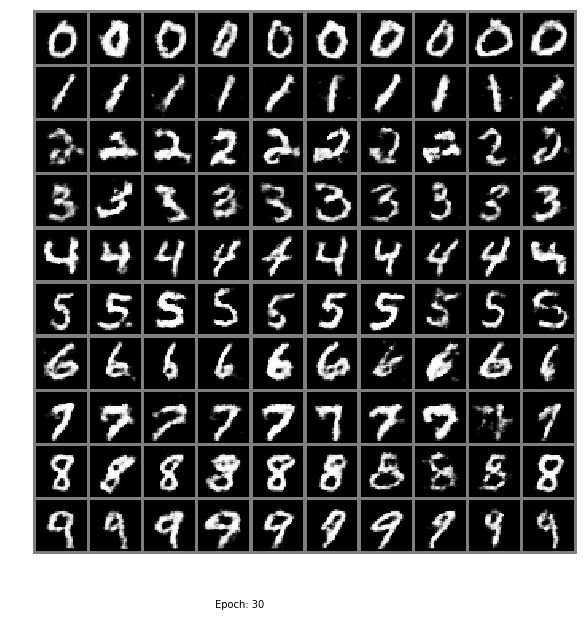

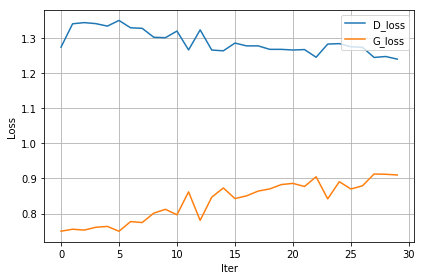

In [38]:
train(mnist_dataloader, epochs=30)

Epoch : [1/60] time: 15.08, loss_d: 1.323, loss_g: 0.804
Epoch : [2/60] time: 16.29, loss_d: 1.345, loss_g: 0.762
Epoch : [3/60] time: 17.44, loss_d: 1.359, loss_g: 0.749
Epoch : [4/60] time: 17.38, loss_d: 1.348, loss_g: 0.768
Epoch : [5/60] time: 17.37, loss_d: 1.314, loss_g: 0.817
Epoch : [6/60] time: 17.37, loss_d: 1.302, loss_g: 0.848
Epoch : [7/60] time: 17.37, loss_d: 1.232, loss_g: 0.939
Epoch : [8/60] time: 17.38, loss_d: 1.089, loss_g: 1.141
Epoch : [9/60] time: 17.46, loss_d: 0.929, loss_g: 1.386
Epoch : [10/60] time: 17.47, loss_d: 0.861, loss_g: 1.520
Epoch : [11/60] time: 17.30, loss_d: 0.642, loss_g: 1.763
Epoch : [12/60] time: 17.36, loss_d: 0.732, loss_g: 1.900
Epoch : [13/60] time: 17.40, loss_d: 0.728, loss_g: 1.939
Epoch : [14/60] time: 17.31, loss_d: 0.662, loss_g: 2.031
Epoch : [15/60] time: 17.34, loss_d: 0.527, loss_g: 2.164
Epoch : [16/60] time: 17.35, loss_d: 0.614, loss_g: 2.188
Epoch : [17/60] time: 17.36, loss_d: 0.698, loss_g: 2.139
Epoch : [18/60] time: 1

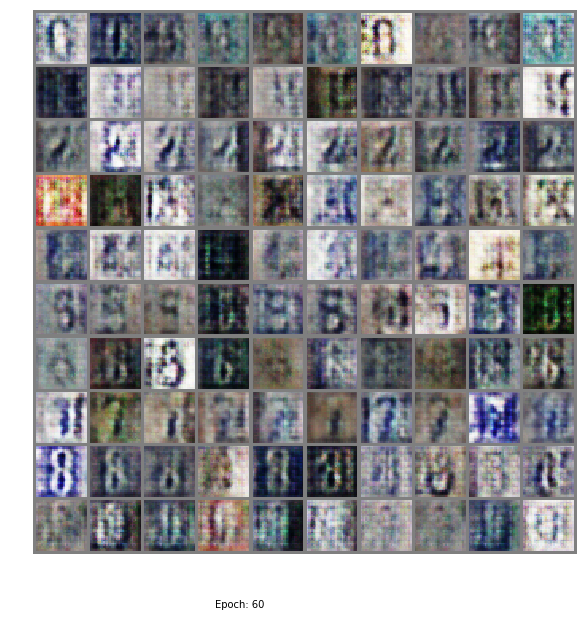

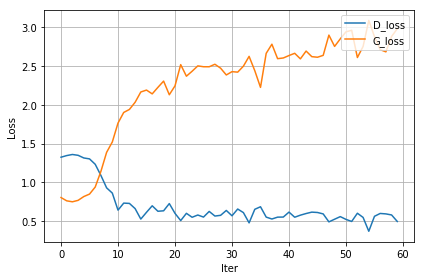

In [13]:
numOutputChannels = 3
train(svhn_dataloader, epochs=60)